In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# IMPORTS
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import xml.etree.ElementTree as et
import datetime
import time
import json
import sys
sys.path.append("..")
from helpers.helper import *
from tqdm import tqdm

In [5]:
# TODO: Path to tracab data
match = Match(
    "../../data/tracab/Group Stage/Austria v North Macedonia/Austria v North Macedonia.xml")


In [14]:

first_half_begin = match.phases[0].start
split1 = first_half_begin.split('T', 1)[1]
split2 = split1.split('.', 1)
aux2 = time.strptime(split2[0], '%H:%M:%S')
timea = datetime.timedelta(hours=aux2.tm_hour, minutes=aux2.tm_min,
                           seconds=aux2.tm_sec).total_seconds() + 0.001 * int(split2[1])

first_half_end = match.phases[0].end
split1 = first_half_end.split('T', 1)[1]
split2 = split1.split('.', 1)
aux2 = time.strptime(split2[0], '%H:%M:%S')
timeb = datetime.timedelta(hours=aux2.tm_hour, minutes=aux2.tm_min,
                           seconds=aux2.tm_sec).total_seconds() + 0.001 * int(split2[1])

second_half_begin = match.phases[1].start
split1 = second_half_begin.split('T', 1)[1]
split2 = split1.split('.', 1)
aux2 = time.strptime(split2[0], '%H:%M:%S')
timec = datetime.timedelta(hours=aux2.tm_hour, minutes=aux2.tm_min,
                           seconds=aux2.tm_sec).total_seconds() + 0.001 * int(split2[1])

second_half_end = match.phases[1].end
split1 = second_half_end.split('T', 1)[1]
split2 = split1.split('.', 1)
aux2 = time.strptime(split2[0], '%H:%M:%S')
timed = datetime.timedelta(hours=aux2.tm_hour, minutes=aux2.tm_min,
                           seconds=aux2.tm_sec).total_seconds() + 0.001 * int(split2[1])

In [18]:

home = np.zeros(len(match.frames))
away = np.zeros(len(match.frames))
noone = np.zeros(len(match.frames))
record_time = np.zeros((len(match.frames), 2))
fase = 1

for j in tqdm(range(len(match.frames))):
    aux = match.frames[j].time.replace('Z', '')
    split1 = aux.split('T', 1)[1]
    split2 = split1.split('.', 1)
    import time
    aux2 = time.strptime(split2[0], '%H:%M:%S')
    time = datetime.timedelta(hours=aux2.tm_hour, minutes=aux2.tm_min,
                              seconds=aux2.tm_sec).total_seconds() + 0.001 * int(split2[1])
    if match.frames[j].ballInPlay == '0':
        noone[j] = 1
    elif match.frames[j].ballPossession == 'Home':
        home[j] = 1
    else:
        away[j] = 1
    period1 = (time-timea)*(timeb-time)
    period2 = (time-timec)*(timed-time)
    if period1 >= 0:
        record_time[j, 0] = 1
        record_time[j, 1] = time-timea
    if period2 >= 0:
        record_time[j, 0] = 2
        record_time[j, 1] = time-timec

100%|██████████| 144438/144438 [00:03<00:00, 37464.85it/s]


In [23]:

# Possession data
# rows = mins (1..48 for 1H, then 1..X for 2H)
# cols = (# frames with home possession, # frames with away possession, # frames where no one has possession, minute)
# TODO: change the number of rows to the number of minutes in the match
pos_per_min = np.zeros((96, 4))

prev = 0
aux = 0
l = 0
for i in tqdm(range(len(match.frames))):
    k = record_time[i, 1] // 60

    if k == aux + 1:
        pos_per_min[l, :] = [sum(home[prev:i]), sum(
            away[prev:i]), sum(noone[prev:i]), record_time[i, 1] // 60]
        l = l + 1
        prev = i + 1
    aux = k

100%|██████████| 144438/144438 [00:00<00:00, 573323.21it/s]


In [24]:
# CODE BY rserrat - COUNT EVENTS IN TIME RANGE WITH WYSCOUT DATA
# Snippet $470

# TODO: path to wyscout data
filename = "../../data/wyscout/5111384/5111384_events.json"

# TODO: change team codes (swe=home, pol=away)
id_austria = '9109'
id_north_macedonia = '10073'

In [25]:
def events_time_range(filename, event_type, period, t_start, t_end, team=None):
    # Get data
    with open(filename, "r") as f:
        data = json.load(f)

    # Number of instances
    count = 0
    events = []

    # Iterate through events
    for e in data["events"]:

        # Check period
        if e["matchPeriod"] != period:
            continue

        # Check event in time interval
        time = e["minute"]*60 + e["second"]  # event time in secs
        if (time < t_start):
            continue  # skip to next iteration
        elif (time > t_end):
            break   # stop search

        # Check proper team
        if team is not None:
            if e["team"]["id"] != team:
                continue

        # Check primary and secondary event types
        if e["type"]["primary"] == event_type or event_type in e["type"]["secondary"]:
            count += 1
            events.append(e)

    return count, events

In [28]:


# TODO: change min1H to total number of minutes in the first half
min1H = 47
passes_austria_1 = np.zeros(min1H)  # passes per team in first half
passes_north_macedonia_1 = np.zeros(min1H)

for i in range(0, min1H):
    # events of type "pass" in the first half by Austria
    c, e = events_time_range(
        filename, "pass", "1H", (pos_per_min[i, 3]-1)*60, pos_per_min[i, 3]*60-1, team=int(id_austria))
    passes_austria_1[i] = c

# events of type "pass" in the first half by North Macedonia
    c, e = events_time_range(
        filename, "pass", "1H", (pos_per_min[i, 3]-1)*60, pos_per_min[i, 3]*60-1, team=int(id_north_macedonia))
    passes_north_macedonia_1[i] = c

# TODO: change min2H to total number of minutes in the second half
min2H = 49
# min2H = 48
passes_austria_2 = np.zeros(min2H)  # passes per team in second half
passes_north_macedonia_2 = np.zeros(min2H)
for i in range(0, min2H):
    # events of type "pass" in the second half by sweden
    c, e = events_time_range(filename, "pass", "2H",
                             (i+45)*60, (i+46)*60-1, team=int(id_austria))
    passes_austria_2[i] = c

# events of type "pass" in the second half by poland
    c, e = events_time_range(filename, "pass", "2H",
                             (i+45)*60, (i+46)*60-1, team=int(id_north_macedonia))
    passes_north_macedonia_2[i] = c

# CODE BY rserrat - PLOT PASSES/POSSESSION PER MINUTE
# Check possession
# total posession
frames_austria = np.sum(pos_per_min[:, 0])
frames_macedonia = np.sum(pos_per_min[:, 1])
pos_austria = frames_austria/(frames_austria+frames_macedonia)
pos_macedonia = 1 - pos_austria
print(f"Possession Austria = {pos_austria*100:.2f}%")
print(f"Possession North Macedonia = {pos_macedonia*100:.2f}%")

# Get minutes array s.t. no repeats
minutes = pos_per_min[:, 3]
minutes_unique = np.arange(1, len(minutes)+1)

# Get passes for full match
passes_swe = np.concatenate((passes_austria_1, passes_austria_2))
passes_pol = np.concatenate(
    (passes_north_macedonia_1, passes_north_macedonia_2))


Possession Austria = 60.06%
Possession North Macedonia = 39.94%


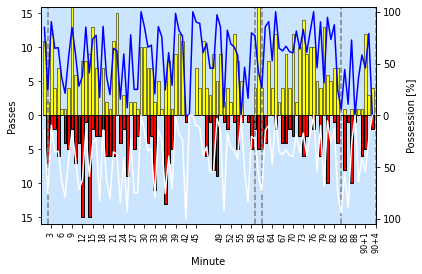

In [33]:

# Create plot
# TODO: update ylim, yticks, yticklabels to fit the data
fig, ax = plt.subplots()
ax.bar(minutes_unique, passes_swe, color=(
    1, 1, 3/255), edgecolor="black", linewidth=.5)
ax.bar(minutes_unique, -passes_pol, color="r", edgecolor="black")
ax.set_xlabel("Minute")
ax.set_xlim(minutes_unique[0]-1, minutes_unique[-1]+1)
ax.set_ylabel("Passes")
ax.set_ylim(-16, 16)
ax.set_yticks([-15, -10, -5, 0, 5, 10, 15])
ax.set_yticklabels([15, 10, 5, 0, 5, 10, 15])
ax.set_facecolor((204/255, 229/255, 1.))

# Minute labels
min_ticks = []
min_lbls = []
for m in minutes[0:min1H]:
    if not m % 3 == 0:
        continue
    min_ticks.append(m)
    if m <= 45:
        min_lbls.append(f"{int(m)}")
    else:
        min_lbls.append(f"45+{int(m-45)}")

for m in minutes[min1H:]:
    if not m % 3 == 1:
        continue
    m2 = int(m+45)
    min_ticks.append(m2+3)
    if m2 <= 90:
        min_lbls.append(f"{m2}")
    else:
        min_lbls.append(f"90+{m2-90}")
ax.set_xticks(min_ticks)
ax.set_xticklabels(min_lbls, fontsize=8, rotation=90)

# Get possession
frames_austria = pos_per_min[:, 0]
frames_macedonia = pos_per_min[:, 1]
frames_tot = frames_austria + frames_macedonia

# avoid divide by zero (set to 0). Note that pol != 1-swe due to this!
possession_swe = np.divide(frames_austria, frames_tot, out=np.zeros_like(
    frames_tot), where=frames_tot != 0)
possession_pol = np.divide(frames_macedonia, frames_tot, out=np.zeros_like(
    frames_tot), where=frames_tot != 0)

# Plot possession
# TODO: update ylim, yticks and yticklabels to fit the data
ax2 = ax.twinx()
ax2.plot(minutes_unique, possession_swe*100, color="blue")
ax2.plot(minutes_unique, -possession_pol*100, color="white")
ax2.set_ylabel("Possession [%]")
ax2.set_ylim(-105, 105)
ax2.set_yticks([-100, -50, 0, 50, 100])
ax2.set_yticklabels([100, 50, 0, 50, 100])

# Add goals (with minutes normalized to account for overtime at the end of 1H)
# TODO: update goal min with the minutes of the goals
goal_min = [2, 59+3, 61+3, 84+3, 94+3]
for g in goal_min:
    ax.axvline(g, ls="--", color="tab:gray")

plt.savefig('../../upload/possession_passes.png', dpi=300)
plt.show()
